In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd /notebooks/

/notebooks


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import trange, tqdm
from digital_twin_library import SubsetSampler, corr
import seaborn as sns
from neuralpredictors.data.datasets import FileTreeDataset
from neuralpredictors.measures.modules import PoissonLoss
from torch.utils.data import DataLoader
from digital_twin_library import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

from neuralpredictors.data.transforms import (
    ToTensor,
    NeuroNormalizer,
    ScaleInputs,
)
from neuralpredictors.data.samplers import RepeatsBatchSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Configure the dataset, samplers and loaders

In [4]:
root_dir = 'data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [ScaleInputs(scale=0.25), ToTensor(torch.cuda.is_available())]
transforms.insert(0, NeuroNormalizer(dat))
dat.transforms.extend(transforms)

train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
val_sampler = SubsetSampler(dat.trial_info.tiers == 'validation', shuffle=False)

train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)
val_loader = DataLoader(dat, sampler=val_sampler, batch_size=64)

# Classical experiments on the model

Load the model from storage

In [5]:
model = ConvModel(layers=3, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372)
state_dict = torch.load('models/model.pt')
model.load_state_dict(state_dict)
model.to(device)


ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
  )
  (readout): GaussianReadout()
)

Find good neurons

In [9]:
with torch.no_grad():
    val_corrs = get_correlations(model, val_loader)
best = np.argsort(-val_corrs)

Compute spike triggered average

In [18]:
imgs, responses = [], []
idx = best[:12]
for _ in range(500):
    noise = torch.randn(100, 1, 36, 64).to(device)
    with torch.no_grad():
        resp = model(noise).cpu().numpy()[:, idx]
    responses.append(resp)
    imgs.append(noise.cpu().numpy())
imgs = np.concatenate(imgs, axis=0)
responses = np.concatenate(responses, axis=0)
responses = (responses - responses.mean(axis=0)) / responses.std(axis=0)

Compute spike triggered average

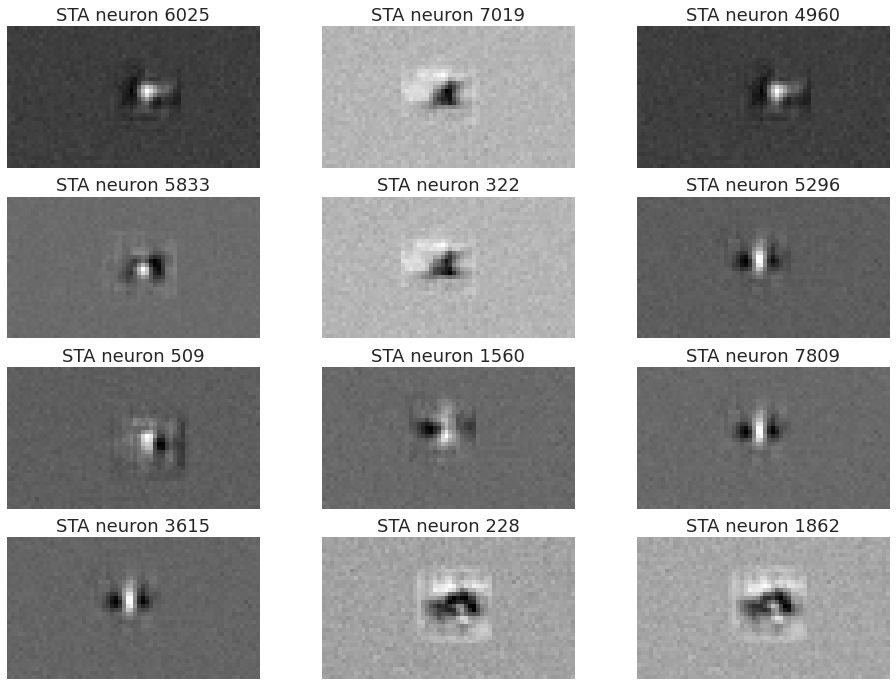

In [50]:
stas = (imgs * responses[..., None, None]).mean(axis=0)

with sns.axes_style('white'):
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, sta, a in zip(best, stas, ax.flatten()):
        a.imshow(sta.squeeze(), cmap='gray')
        a.axis('off')
        a.set_title(f'STA neuron {i}')

# Gradient RFs

In [21]:
rfs = []
for i in best[:12]:
    x = torch.zeros(1, 1, 36, 64).to(device)
    x.requires_grad = True
    r = model(x)
    r[0, i].backward()
    rfs.append(x.grad.cpu().numpy().squeeze())
    

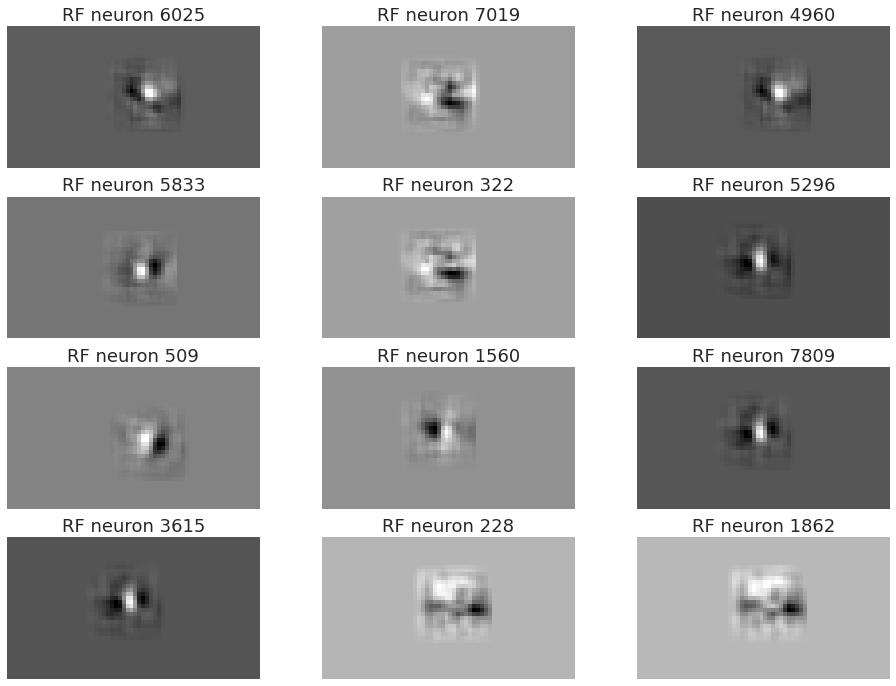

In [49]:

with sns.axes_style('white'):
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, rf, a in zip(range(len(rfs)), rfs, ax.flatten()):
        a.imshow(rf.squeeze(), cmap='gray')
        a.axis('off')
        a.set_title(f'RF neuron {best[i]}')

# MEIs

In [73]:
norm = 2.0
meis = []
for neuron_index in tqdm(best[:12]):
    
    x = torch.randn(1,1,36, 64).to(device)
    x.requires_grad = True

    optimizer = torch.optim.SGD([x], lr=0.1, weight_decay=1e-1)
    optim_curve = []
    for e in range(1000):
        optimizer.zero_grad()
        r = model(x / x.norm() * norm)
        loss = -r[0, neuron_index]
        loss.backward()
        optim_curve.append(-loss.item())
        optimizer.step()
        x.data = x.data / x.data.norm() * norm
    mei = x.cpu().detach().numpy().squeeze()
    meis.append(mei)


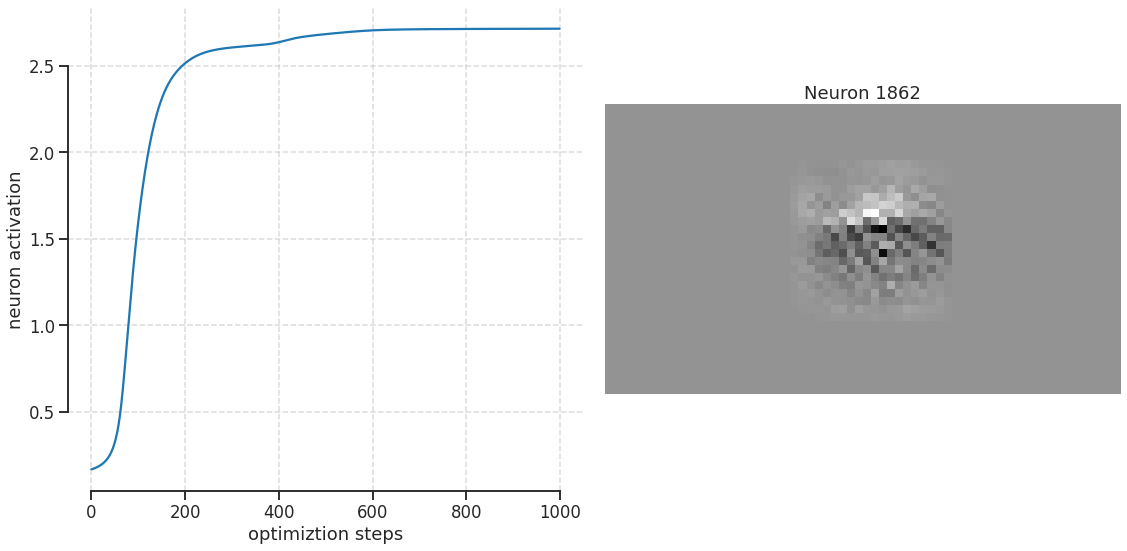

In [74]:
sns.set_context('talk')
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(optim_curve)
    ax[1].imshow(mei, cmap='gray')
    ax[1].axis('off')
    ax[0].set(
        xlabel='optimiztion steps',
        ylabel='neuron activation'
    )
    ax[0].grid(True, ls='--', alpha=0.7)
    ax[1].set_title(f'Neuron {neuron_index}')
    sns.despine(ax=ax[0], trim=True)
    fig.tight_layout()

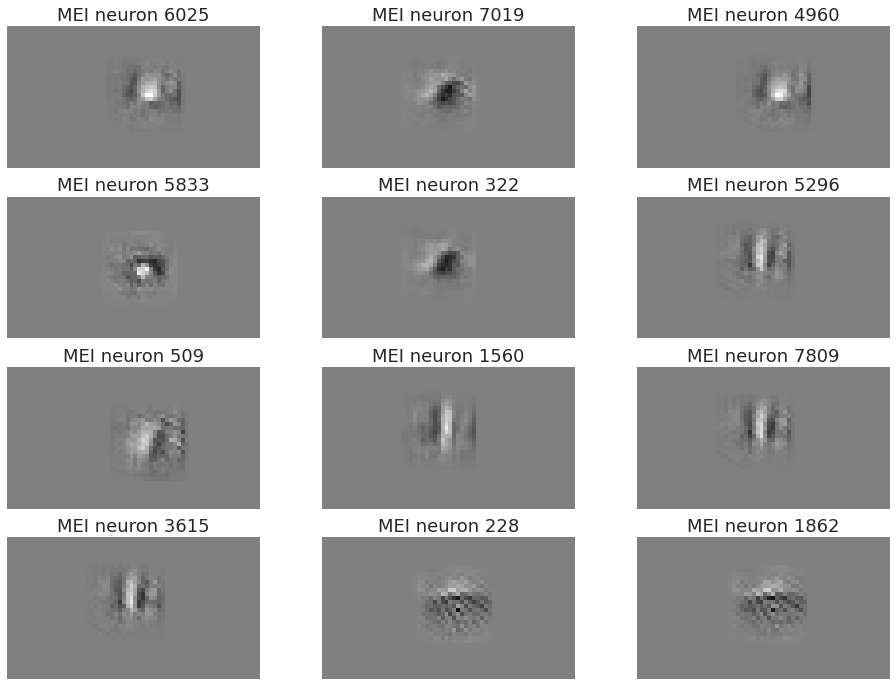

In [75]:

v = np.max(np.abs(np.concatenate(meis, axis=0)))
with sns.axes_style('white'):
    fig, ax = plt.subplots(4, 3, figsize=(16, 12))
    for i, mei, a in zip(best, meis, ax.flatten()):
        a.imshow(mei.squeeze(), cmap='gray', vmin=-v, vmax=v)
        a.axis('off')
        a.set_title(f'MEI neuron {i}')

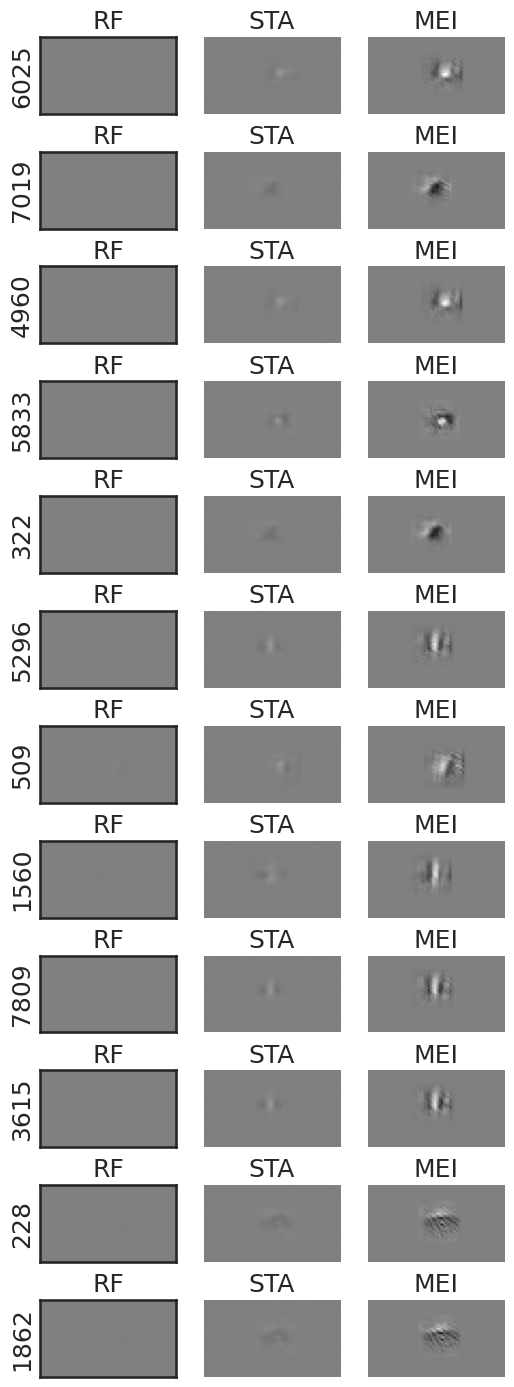

In [77]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(12, 3, figsize=(6, 18), dpi=100)
    for i, rf, sta, mei, a in zip(best, rfs, stas, meis, ax):
        a[0].imshow(rf.squeeze(), cmap='gray', vmin=-v, vmax=v)
        a[0].set_title('RF')
        a[1].imshow(sta.squeeze(), cmap='gray', vmin=-v, vmax=v)
        a[1].axis('off')
        a[1].set_title('STA')
        a[2].imshow(mei.squeeze(), cmap='gray', vmin=-v, vmax=v)
        a[2].axis('off')
        a[2].set_title('MEI')
        a[0].set_ylabel(f'{i}')
        a[0].set(
            xticks=[], yticks=[],
        )
